In [1]:
import pandas as pd
import numpy as np
import os
import cupy as cp
import sklearn as sk
import xgboost as xgb
import matplotlib as plt

In [2]:
dir='/data/gent/vo/001/gvo00174/Arian/python'

# Change the current working directory
os.chdir(dir)

# Verify the change
print("Current Working Directory:", os.getcwd())

Current Working Directory: /kyukon/data/gent/vo/001/gvo00174/Arian/python


In [3]:
metaData=pd.read_csv("/data/gent/vo/001/gvo00174/Arian/meta_data.csv")
metaData=pd.DataFrame(metaData).reset_index(drop=True)
metaData = metaData.drop(metaData.columns[0], axis=1)

In [4]:
metaData.head()

,idBiospe,idwoman,cpn234_tad2,cpn234_tas2,cpn234_tad3,cpn234_tas3,cpn234_tad4,cpn234_tas4,cpn234_tad5,cpn234_tas5,...,c_igu_muacaz6,c_igu_bmi9,c_igu_hcaz9,c_igu_muacaz9,c_igu_bmi12,c_igu_hcaz12,c_igu_muacaz12,biospe_neonatal_mortality,last_visit_death,_list_tad
0,101,40262,6.0,9.0,5.0,12.0,7.0,12.0,NaN,NaN,...,0.08,NaN,NaN,NaN,NaN,NaN,NaN,0,.,3
1,102,16016_2,8.0,12.0,8.0,12.0,8.0,14.0,NaN,NaN,...,-1.20,NaN,NaN,NaN,NaN,NaN,NaN,0,.,3
2,103,40274,6.0,10.0,7.0,10.0,6.0,11.0,NaN,NaN,...,-0.61,NaN,NaN,NaN,NaN,NaN,NaN,0,.,3
3,104,16025_3,6.0,10.0,7.0,11.0,6.0,11.0,NaN,NaN,...,0.09,NaN,NaN,NaN,NaN,NaN,NaN,0,.,3
4,105,40254,5.0,10.0,6.0,10.0,6.0,11.0,NaN,NaN,...,-0.95,NaN,NaN,NaN,NaN,NaN,NaN,0,.,3


In [5]:
sampleSheet = pd.read_csv("/data/gent/vo/001/gvo00174/methylome/sampleSheet.csv")

In [6]:
sampleSheet.head()

,Sample_ID,Plate_ID,Sample_Well,Sentrix_ID,Sentrix_Position,Date,Basename
0,102,BC78,D1,2.060000e+11,R04C01,13/09/2022,206402350107_R04C01
1,103,BC79,C4,2.070000e+11,R03C01,28/09/2022,206644410180_R03C01
2,104,BC78,C2,2.060000e+11,R03C01,13/09/2022,206402350116_R03C01
3,106,BC78,G12,2.060000e+11,R07C01,13/09/2022,206425830038_R07C01
4,107,BC79,B3,2.070000e+11,R02C01,28/09/2022,206644410103_R02C01


In [7]:
# Load data
methylome = pd.read_csv("/data/gent/vo/001/gvo00174/methylome/20240411MethylomeDataBetasWithProbId.csv")

# Process methylome data
methylome = methylome.set_index("ProbeID").T
methylome = methylome.reset_index().rename(columns={"index": "Basename"})
methylome = methylome.merge(sampleSheet[["Basename", "Sample_ID"]], on="Basename", how="left")
methylome = methylome.drop(columns=["Basename"]).rename(columns={"Sample_ID": "idBiospe"})
methylome = methylome[["idBiospe"] + [col for col in methylome.columns if col != "idBiospe"]]

# Assuming metaData is another dataframe that needs to be loaded
meta_data = metaData  # Replace with actual path to metaData file
methylome = methylome.merge(meta_data[["idBiospe", "code_bep_n"]], on="idBiospe", how="left")
methylome = methylome.rename(columns={"code_bep_n": "class"})
methylome["class"] = methylome["class"] - 1
methylome["timePoint"] = "Pn56"
methylome = methylome.sort_values(by=["timePoint", "idBiospe"])
methylome = methylome[["timePoint", "idBiospe", "class"] + [col for col in methylome.columns if col not in ["timePoint", "idBiospe", "class"]]]

In [8]:
methylome.head()

,timePoint,idBiospe,class,cg14817997,cg26928153,cg16269199,cg13869341,cg14008030,cg12045430,cg20826792,...,cg17939569,cg13365400,cg02600718,cg21106100,cg08265308,cg10488260,cg14273923,cg09748881,cg07587934,cg16855331
0,Pn56,102,2,0.370702,0.906810,0.729572,0.919086,0.748790,0.131226,0.131664,...,NaN,NaN,0.204499,0.233191,0.410137,0.116070,0.238445,NaN,0.806420,0.415945
1,Pn56,103,2,0.352146,0.475196,0.227495,0.772063,0.737550,0.225267,0.213943,...,0.741882,0.607857,0.247206,0.637003,0.849188,0.504236,0.440615,0.823711,0.777729,0.567635
2,Pn56,104,1,0.307659,0.872990,0.657483,0.819911,0.548639,0.126281,0.118666,...,0.227705,0.235356,0.231018,0.234811,0.420113,0.139597,0.223410,0.199689,0.807111,0.493500
3,Pn56,106,0,0.369779,0.875169,0.725316,0.909891,0.587720,0.091899,0.120725,...,0.815071,0.513299,0.249403,0.745385,0.924718,0.591618,0.713801,0.852716,0.782532,0.491458
4,Pn56,107,0,0.325455,0.826068,0.612782,0.738983,0.641742,0.245444,0.265556,...,NaN,NaN,0.261898,0.229423,0.438345,0.211108,NaN,NaN,0.815358,0.434790


In [9]:
methylome = methylome.drop("idBiospe", axis=1)
methylome = methylome.drop("timePoint", axis=1)

In [10]:
methylome.head()

,class,cg14817997,cg26928153,cg16269199,cg13869341,cg14008030,cg12045430,cg20826792,cg20253340,cg02404219,...,cg17939569,cg13365400,cg02600718,cg21106100,cg08265308,cg10488260,cg14273923,cg09748881,cg07587934,cg16855331
0,2,0.370702,0.906810,0.729572,0.919086,0.748790,0.131226,0.131664,0.672684,0.675035,...,NaN,NaN,0.204499,0.233191,0.410137,0.116070,0.238445,NaN,0.806420,0.415945
1,2,0.352146,0.475196,0.227495,0.772063,0.737550,0.225267,0.213943,0.688005,0.659342,...,0.741882,0.607857,0.247206,0.637003,0.849188,0.504236,0.440615,0.823711,0.777729,0.567635
2,1,0.307659,0.872990,0.657483,0.819911,0.548639,0.126281,0.118666,0.791500,0.813271,...,0.227705,0.235356,0.231018,0.234811,0.420113,0.139597,0.223410,0.199689,0.807111,0.493500
3,0,0.369779,0.875169,0.725316,0.909891,0.587720,0.091899,0.120725,0.561473,0.782631,...,0.815071,0.513299,0.249403,0.745385,0.924718,0.591618,0.713801,0.852716,0.782532,0.491458
4,0,0.325455,0.826068,0.612782,0.738983,0.641742,0.245444,0.265556,0.743723,0.654437,...,NaN,NaN,0.261898,0.229423,0.438345,0.211108,NaN,NaN,0.815358,0.434790


In [11]:
methylome.shape

(219, 865860)

[0]	train-mlogloss:1.03681	test-mlogloss:1.41504
[10]	train-mlogloss:0.13594	test-mlogloss:1.61765
Top 10 important CpG IDs:
      feature  importance
0  cg14817997         5.0
1  cg05823759         2.0
2  cg17166794         2.0
3  cg04226898         1.0
4  cg00963223         1.0
5  cg24544798         1.0
6  cg05413022         1.0
7  cg15706577         1.0
8  cg05057794         1.0
9  cg17294952         1.0


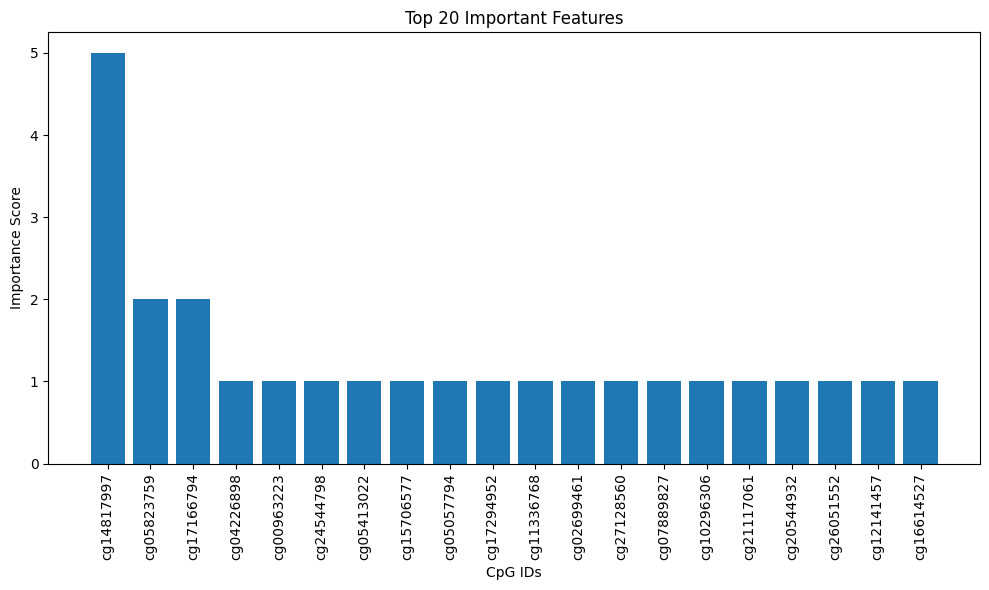

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate features and target
X = methylome.drop('class', axis=1)
y = methylome['class']

# Re-encode the labels in the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Move data to GPU
X_train_gpu = cp.array(X_train)
X_test_gpu = cp.array(X_test)
y_train_gpu = cp.array(y_train)
y_test_gpu = cp.array(y_test)

# Create DMatrix objects on GPU, including feature names
dtrain = xgb.DMatrix(X_train_gpu, label=y_train_gpu, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test_gpu, label=y_test_gpu, feature_names=X.columns.tolist())

# param tuning
params = {
    'tree_method': 'hist',  # gpu_hist always gets warnings 
    #'gpu_id': 0,  # Specify the GPU device
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(np.unique(y)),  # Number of unique classes in the target variable
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model
epochs = 100
model = xgb.train(params, dtrain, epochs, evals=[(dtrain, 'train'), (dtest, 'test')], 
                  early_stopping_rounds=10, verbose_eval=10)

# Get feature importance
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame({'feature': importance.keys(), 'importance': importance.values()})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Print top 10 important features
print("Top 10 important CpG IDs:")
print(importance_df.head(10))

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'].head(20), importance_df['importance'].head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Important Features')
plt.xlabel('CpG IDs')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# Print model info
print(model)

In [14]:
print(model)

In [30]:
print(y.shape)
print(y[:20])

(219,)
[2 2 1 0 0 1 2 0 0 2 1 2 2 0 1 0 3 0 3 1]


In [28]:
print(X.var())

cg14817997    0.017297
cg26928153    0.012195
cg16269199    0.009726
cg13869341    0.002517
cg14008030    0.003100
                ...   
cg10488260    0.024097
cg14273923    0.043424
cg09748881    0.053886
cg07587934    0.001881
cg16855331    0.002777
Length: 865859, dtype: float64


In [13]:
y_pred = model.predict(dtest)
print(y_pred)

[[0.1385265  0.49903473 0.13475484 0.22768395]
 [0.16421092 0.42560706 0.18890539 0.22127663]
 [0.1376059  0.1578024  0.45330718 0.25128454]
 [0.19919458 0.5467559  0.11151505 0.14253445]
 [0.44098872 0.23715462 0.10739803 0.21445861]
 [0.33124128 0.10228581 0.16695169 0.39952123]
 [0.22505002 0.11796084 0.0676903  0.58929884]
 [0.2306365  0.33888566 0.17525525 0.25522262]
 [0.60013765 0.12390651 0.15987198 0.11608389]
 [0.21929084 0.14632127 0.2909029  0.34348494]
 [0.5835831  0.26931262 0.04807772 0.09902656]
 [0.29961437 0.31321433 0.21015082 0.17702046]
 [0.09991836 0.0623323  0.07308547 0.7646639 ]
 [0.14102903 0.1208748  0.40389237 0.3342038 ]
 [0.5361877  0.14676431 0.20059876 0.11644924]
 [0.08474422 0.38362584 0.46814767 0.06348225]
 [0.2107756  0.08765074 0.12569763 0.57587606]
 [0.4092626  0.42053372 0.10670984 0.06349391]
 [0.5388125  0.29647988 0.0739342  0.09077343]
 [0.05443745 0.4104694  0.08503636 0.45005682]
 [0.12312007 0.5778813  0.17163412 0.12736456]
 [0.13173945 

In [14]:
from sklearn.metrics import accuracy_score

def compute_accuracy(model, data, labels):
    preds = model.predict(data)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    return accuracy_score(labels, best_preds)

# Compute and print accuracies
train_accuracy = compute_accuracy(model, dtrain, y_train)
test_accuracy = compute_accuracy(model, dtest, y_test)

print(f"Final train mlogloss: {model.eval(dtrain)}")
print(f"Final test mlogloss: {model.eval(dtest)}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Final train mlogloss: [0]	eval-mlogloss:0.13594181103365763
Final test mlogloss: [0]	eval-mlogloss:1.61764624579386274
Train Accuracy: 1.0000
Test Accuracy: 0.2273



Top 10 Most Important Features:
cg14817997: 5.0
cg05823759: 2.0
cg17166794: 2.0
cg12045430: 1.0
cg01803908: 1.0
cg24669183: 1.0
cg24159721: 1.0
cg08858441: 1.0
cg10037654: 1.0
cg09961319: 1.0


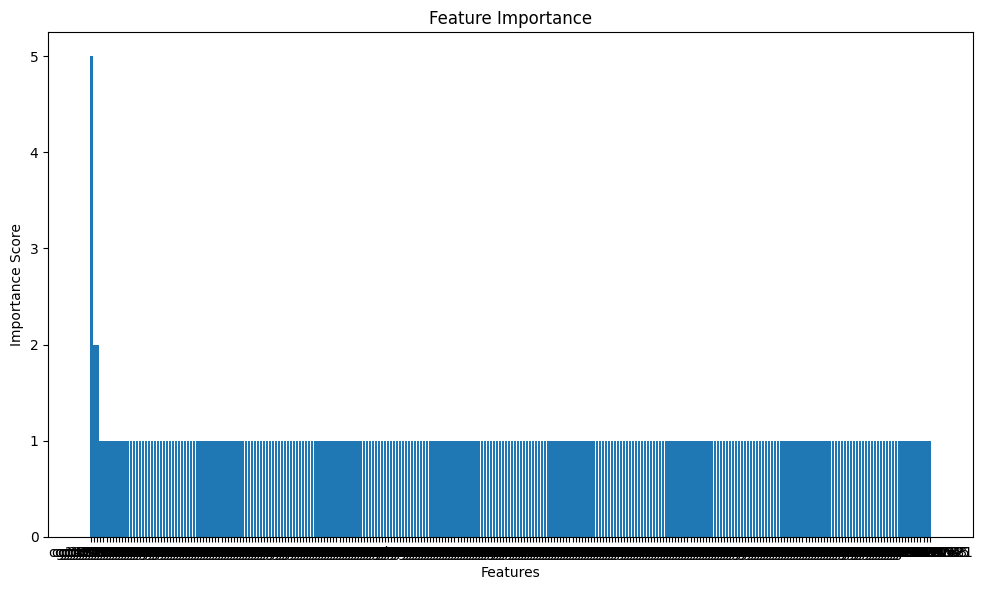

In [15]:
# Get feature importance
importance = model.get_score(importance_type='weight')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most important features
print("\nTop 10 Most Important Features:")
for feature, score in importance[:10]:
    print(f"{feature}: {score}")

# If you want to visualize the feature importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), [score for feature, score in importance])
plt.xticks(range(len(importance)), [feature for feature, score in importance], rotation='horizontal')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

In [17]:
print(model.get_score(importance_type='weight'))  # Feature counts
print(model.get_score(importance_type='gain'))    # Feature gains
print(model.get_score(importance_type='cover'))

{'cg14817997': 5.0, 'cg12045430': 1.0, 'cg01803908': 1.0, 'cg24669183': 1.0, 'cg24159721': 1.0, 'cg08858441': 1.0, 'cg10037654': 1.0, 'cg09961319': 1.0, 'cg19411932': 1.0, 'cg12285627': 1.0, 'cg06919059': 1.0, 'cg05321646': 1.0, 'cg12445832': 1.0, 'cg11851804': 1.0, 'cg08186992': 1.0, 'cg25215298': 1.0, 'cg02968844': 1.0, 'cg22114309': 1.0, 'cg02835406': 1.0, 'cg10175834': 1.0, 'cg01922485': 1.0, 'cg05929553': 1.0, 'cg20185617': 1.0, 'cg00146669': 1.0, 'cg12219387': 1.0, 'cg25282454': 1.0, 'cg25619287': 1.0, 'cg22225577': 1.0, 'cg17026072': 1.0, 'cg06002660': 1.0, 'cg11549166': 1.0, 'cg23037871': 1.0, 'cg03754143': 1.0, 'cg17254222': 1.0, 'cg07693617': 1.0, 'cg05937603': 1.0, 'cg02975102': 1.0, 'cg00581154': 1.0, 'cg13460118': 1.0, 'cg19902591': 1.0, 'cg13119178': 1.0, 'cg18810133': 1.0, 'cg19564590': 1.0, 'cg01980735': 1.0, 'cg18994297': 1.0, 'cg07240000': 1.0, 'cg19367256': 1.0, 'cg16895116': 1.0, 'cg19273683': 1.0, 'cg27058404': 1.0, 'cg16051685': 1.0, 'cg02716406': 1.0, 'cg11912093

In [18]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Predict labels and probabilities
y_pred = model.predict(dtest)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_prob = model.predict(dtest)  # This already gives probabilities, no need for output_margin

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion matrix and derived metrics
cm = confusion_matrix(y_test, y_pred)
n_classes = len(np.unique(y_test))

sensitivity = []
specificity = []
ppv = []
npv = []

for i in range(n_classes):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    
    sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    ppv.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npv.append(tn / (tn + fn) if (tn + fn) > 0 else 0)

balanced_accuracy = (np.mean(sensitivity) + np.mean(specificity)) / 2

# AUC calculation
y_test_bin = label_binarize(y_test, classes=range(n_classes))
auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')

# Print results
metrics = {
    'Accuracy': accuracy,
    'Kappa': kappa,
    'Sensitivity': np.mean(sensitivity),
    'Specificity': np.mean(specificity),
    'Positive Predictive Value': np.mean(ppv),
    'Negative Predictive Value': np.mean(npv),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Balanced Accuracy': balanced_accuracy,
    'AUC': auc
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.2273
Kappa: -0.0374
Sensitivity: 0.2259
Specificity: 0.7402
Positive Predictive Value: 0.2410
Negative Predictive Value: 0.7389
Precision: 0.2394
Recall: 0.2273
F1 Score: 0.2281
Balanced Accuracy: 0.4830
AUC: 0.4622


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_metrics(y_true, y_pred_proba):
    y_pred = np.argmax(y_pred_proba, axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # For multiclass AUC
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    auc = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

# Create DMatrix for training data if not already done
dtrain = xgb.DMatrix(X_train, label=y_train)

# Make predictions on training set
y_train_prob = model.predict(dtrain)

# Make predictions on test set
y_test_prob = model.predict(dtest)

# Calculate metrics for training set
train_metrics = calculate_metrics(y_train, y_train_prob)

# Calculate metrics for test set
test_metrics = calculate_metrics(y_test, y_test_prob)

# Print results
print("Training Set Performance:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Performance:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Set Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000

Test Set Performance:
Accuracy: 0.2273
Precision: 0.2394
Recall: 0.2273
F1 Score: 0.2281
AUC: 0.4622


In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

# Create an XGBClassifier
xgb_model = XGBClassifier(
    tree_method='hist',
    device='cuda',
    #gpu_id=0,  # Use GPU 0
    objective='multi:softprob',  # Changed from softmax to softprob
    eval_metric='mlogloss',  # Changed from metric to eval_metric
    num_class=4
)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='accuracy',
    #n_jobs=1,  # Changed from -1 to 1 for GPU usage
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train_gpu.get(), y_train_gpu.get())

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_gpu.get())
y_pred = best_model.predict(X_test_gpu.get())
# Example output
print("Predicted probabilities:", y_pred_proba[:5])
print("Predicted classes:", y_pred[:5])

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/user/gent/475/vsc47589/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:12:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=  51.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=  52.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=  52.0s


KeyboardInterrupt: 

Params: {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 1, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'device': 'cuda', 'num_class': 4}, n_estimators: 100, Score: 1.384686874119413
Params: {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 1, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'device': 'cuda', 'num_class': 4}, n_estimators: 200, Score: 1.384686874119413
Params: {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 1, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'device': 'cuda', 'num_class': 4}, n_estimators: 300, Score: 1.384686874119413
Params: {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 3, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'device': 'cuda', 'num_class': 4}, n_estimators: 100, Score: 1.3859705460389733
Params: {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 3, 'objective': 'multi:softprob', 'eval_metric': 'mloglos

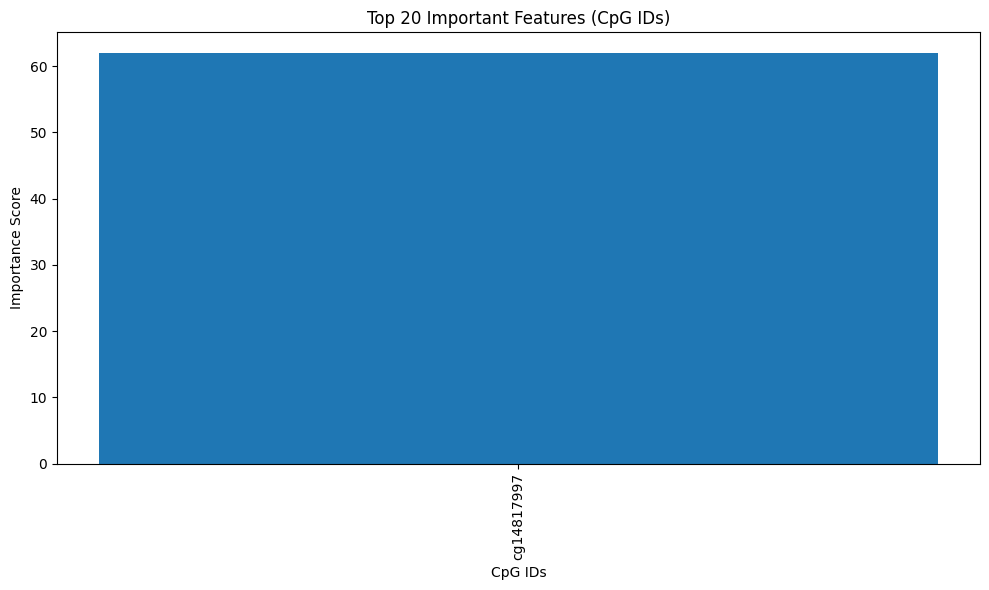

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'eta': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [100, 200, 300]
}

# Fixed parameters
fixed_params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'device': 'cuda',  # Changed from gpu_id to device
    'num_class': len(np.unique(y))
}

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train_gpu, label=y_train_gpu, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test_gpu, label=y_test_gpu, feature_names=X.columns.tolist())

# Function to perform cross-validation
def xgb_cv(params, num_boost_round):
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        nfold=3,
        stratified=True,
        early_stopping_rounds=10,
        verbose_eval=False
    )
    return cv_results['test-mlogloss-mean'].iloc[-1]

# Perform grid search
best_score = float('inf')
best_params = None

for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for min_child_weight in param_grid['min_child_weight']:
            for n_estimators in param_grid['n_estimators']:
                params = {
                    'max_depth': max_depth,
                    'eta': eta,
                    'min_child_weight': min_child_weight,
                    **fixed_params
                }
                score = xgb_cv(params, num_boost_round=n_estimators)
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_n_estimators = n_estimators
                print(f"Params: {params}, n_estimators: {n_estimators}, Score: {score}")

print("Best parameters:", best_params)
print("Best n_estimators:", best_n_estimators)
print("Best cross-validation score:", best_score)

# Train the final model with the best parameters
best_model = xgb.train(best_params, dtrain, num_boost_round=best_n_estimators)

# Make predictions
y_pred_proba = best_model.predict(dtest)
y_pred = y_pred_proba.argmax(axis=1)

# Example output
print("Predicted probabilities:", y_pred_proba[:5])
print("Predicted classes:", y_pred[:5])

# Get feature importance
importance = best_model.get_score(importance_type='weight')
importance_df = pd.DataFrame({'feature': importance.keys(), 'importance': importance.values()})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Print top 10 important features
print("\nTop 10 important CpG IDs:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'].head(20), importance_df['importance'].head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Important Features (CpG IDs)')
plt.xlabel('CpG IDs')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

In [17]:
print("Best parameters:", best_params)
print("Best n_estimators:", best_n_estimators)
print("Best cross-validation score:", best_score)

Best parameters: {'max_depth': 3, 'eta': 0.2, 'min_child_weight': 1, 'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'tree_method': 'hist', 'device': 'cuda', 'num_class': 4}
Best n_estimators: 100
Best cross-validation score: 1.3760341672248924


In [26]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, accuracy_score
import numpy as np
import cupy as cp

# Convert y_test_gpu from CuPy to NumPy
y_test_cpu = cp.asnumpy(y_test_gpu)

# Ensure y_pred_proba and y_pred are NumPy arrays (they already are, but just to be sure)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.array(y_pred)

# Calculate AUC
auc = roc_auc_score(y_test_cpu, y_pred_proba, multi_class='ovr', average='weighted')

# Calculate Kappa
kappa = cohen_kappa_score(y_test_cpu, y_pred)

# Calculate F1 score
f1 = f1_score(y_test_cpu, y_pred, average='weighted')

# Calculate Accuracy
accuracy = accuracy_score(y_test_cpu, y_pred)

# Print the metrics
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

AUC: 0.5000
Kappa: 0.0000
F1 Score: 0.1000
Accuracy: 0.2500


In [25]:
print(type(y_test_gpu))
print(type(y_pred_proba))
print(type(y_pred))

<class 'cupy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
